# 🚢 K-Nearest Neighbors (KNN) Workshop: Titanic Implementation

## 👨‍🎓 Student Information
**Name:** Ali Cihan Ozdemir  
**Student ID:** 9091405  

**Name:** Danda, Lohith Reddy  
**Student ID:** 9054470  

## 📘 Workshop Summary
This notebook demonstrates a complete Machine Learning Pipeline using the **Titanic Dataset**.
We implement the **Machine Learning Pipeline Pattern** to architect modular, reproducible ML code, integrating a **Remote Database** (sqlite simulation) and a **Data Stream**.

### 🎯 Objectives
1. **Connect** to a remote database (SQLite `titanic.db`) populated by a streaming service.
   > *Note: For a production deployment, replace the SQLite `DB_FILE` connection string with a standard `postgresql://` or `mysql://` URI pointing to an AWS RDS or Azure SQL instance. The code structure remains identical.*
2. **Preprocess** the raw Titanic data (handle missing values, encode categorical features).
3. **Train** a K-Nearest Neighbors (KNN) classifier to predict survival.
4. **Visualize** the results in a Dynamic Dashboard that updates in real-time as new data arrives.


## 🏗️ 1. Database Connection & Data Loading

We connect to `titanic.db`, which is being populated by our `stream_titanic.py` script.

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import time
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, clear_output
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Database Configuration
DB_FILE = 'titanic.db'

def load_data_from_db():
    """Reads the passengers table from the SQLite database."""
    try:
        conn = sqlite3.connect(DB_FILE)
        df = pd.read_sql_query("SELECT * FROM passengers", conn)
        conn.close()
        return df
    except Exception as e:
        print(f"Error reading database: {e}")
        return pd.DataFrame()

print("Checking Database connection...")
df_initial = load_data_from_db()
if not df_initial.empty:
    print(f"Success! Use {len(df_initial)} records loaded.")
    display(df_initial.head())
else:
    print("Database is empty or not found. Please ensure stream_titanic.py is running.")

Checking Database connection...
Success! Use 891 records loaded.


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 🧹 2. Data Preprocessing Pipeline

We define a `Preprocessor` class to handle cleaning and encoding. This ensures consistency between training and streaming data.

In [2]:
class Preprocessor:
    def __init__(self):
        self.sex_encoder = LabelEncoder()
        self.embarked_encoder = LabelEncoder()
        self.scaler = StandardScaler()
        self.imputer_age = SimpleImputer(strategy='median')
        self.imputer_fare = SimpleImputer(strategy='median')
        self.is_fitted = False

    def fit(self, X):
        """Fit imputer and scaler on training data."""
        # Handle categorical fitting
        # Note: In production, we'd handle unseen labels more robustly.
        self.sex_encoder.fit(['male', 'female'])
        self.embarked_encoder.fit(['S', 'C', 'Q', 'unknown']) # 'unknown' for NaNs

        # Numerical
        self.imputer_age.fit(X[['Age']])
        self.imputer_fare.fit(X[['Fare']])
        
        # Check numerical columns after imputation for scaling fitting
        X_temp = X.copy()
        X_temp['Age'] = self.imputer_age.transform(X[['Age']])
        X_temp['Fare'] = self.imputer_fare.transform(X[['Fare']])
        self.scaler.fit(X_temp[['Age', 'Fare', 'Pclass', 'SibSp', 'Parch']])
        
        self.is_fitted = True

    def transform(self, X):
        """Transform data using fitted parameters."""
        X = X.copy()
        
        # Drop irrelevant features
        drop_cols = ['Name', 'Ticket', 'Cabin', 'PassengerId']
        X = X.drop(columns=[c for c in drop_cols if c in X.columns])
        
        # Encode Sex
        X['Sex'] = X['Sex'].map(lambda s: 1 if s == 'female' else 0) # Manual safer here

        # Encode Embarked
        X['Embarked'] = X['Embarked'].fillna('S') # Default to S
        X['Embarked'] = X['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

        # Impute
        X['Age'] = self.imputer_age.transform(X[['Age']])
        X['Fare'] = self.imputer_fare.transform(X[['Fare']])
        
        # Scale
        X_scaled = self.scaler.transform(X[['Age', 'Fare', 'Pclass', 'SibSp', 'Parch']])
        
        # Combine
        X_final = np.column_stack((X_scaled, X['Sex'], X['Embarked']))
        return X_final

print("Preprocessor class defined.")

Preprocessor class defined.


## 🤖 3. Model Training (KNN)

We will initially train the model on the data currently available in the database.

In [3]:
# Load current data
df = load_data_from_db()

if len(df) > 10:
    # Preprocessing
    preprocessor = Preprocessor()
    X = df.drop(columns=['Survived'])
    y = df['Survived']
    
    preprocessor.fit(X)
    X_processed = preprocessor.transform(X)
    
    # Train/Test Split
    X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)
    
    # Initialize KNN
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train, y_train)
    
    # Evaluate
    y_pred = knn.predict(X_test)
    print(f"Initial Model Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print(classification_report(y_test, y_pred))
else:
    print("Not enough data to train yet. Waiting for stream...")

Initial Model Accuracy: 0.80
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       105
           1       0.78      0.73      0.76        74

    accuracy                           0.80       179
   macro avg       0.80      0.79      0.80       179
weighted avg       0.80      0.80      0.80       179



## 📊 4. Dynamic Dashboard

This section implements the real-time visualization. It polls the database every few seconds, processes new data, updates the counts, and visualizes predictions.

/var/folders/2n/7s2d51jn14q49vthc8fnj1nm0000gn/T/ipykernel_64146/924745292.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Survived', data=df_live, palette='viridis')


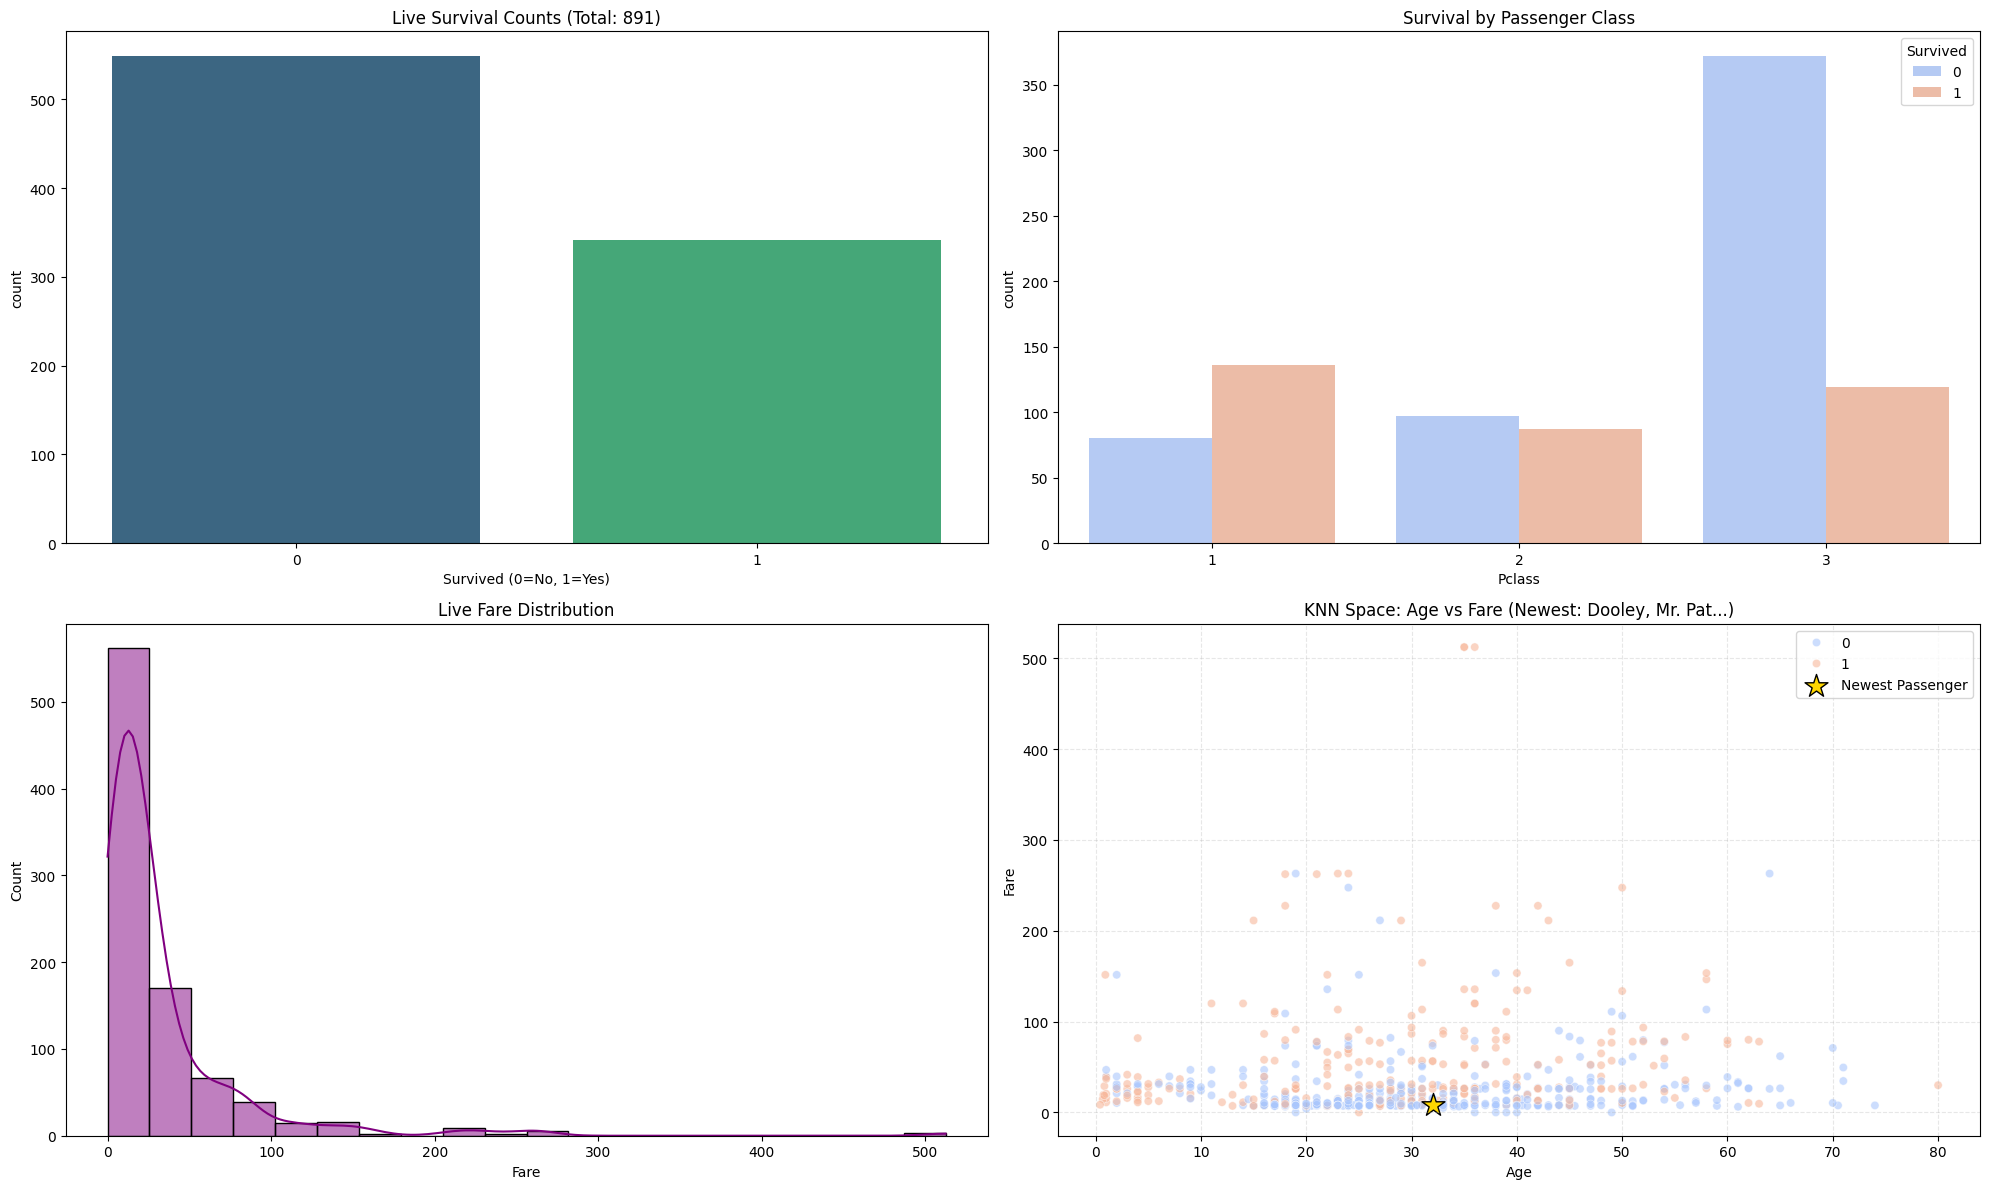

Iteration 9/20 - Last updated: 11:50:50
Total Records: 891
Newest Passenger: Dooley, Mr. Patrick | Survived: 0
Dashboard stopped by user.


In [4]:
# Dynamic Dashboard Settings
UPDATE_INTERVAL = 3 # seconds
MAX_ITERATIONS = 20 # Run for a limited time for demo

try:
    for i in range(MAX_ITERATIONS):
        # 1. Fetch updated data
        df_live = load_data_from_db()
        
        if df_live.empty:
            time.sleep(UPDATE_INTERVAL)
            continue
            
        # 2. Process Data
        if not preprocessor.is_fitted:
             # Fit on initial batch if not already done
            X_live = df_live.drop(columns=['Survived'])
            preprocessor.fit(X_live)
            
        X_live_processed = preprocessor.transform(df_live.drop(columns=['Survived']))
        y_live = df_live['Survived']
        
        # 3. Retrain/Update Model (Optional, or just predict)
        # For this workshop, we'll retrain on all available data to show 'learning'
        knn.fit(X_live_processed, y_live)
        
        # 4. Visualization
        clear_output(wait=True)
        plt.figure(figsize=(20, 12)) # Larger figure for 4 plots
        
        # Plot 1: Survival Count
        plt.subplot(2, 2, 1)
        sns.countplot(x='Survived', data=df_live, palette='viridis')
        plt.title(f'Live Survival Counts (Total: {len(df_live)})')
        plt.xlabel('Survived (0=No, 1=Yes)')
        
        # Plot 2: Class Distribution
        plt.subplot(2, 2, 2)
        sns.countplot(x='Pclass', hue='Survived', data=df_live, palette='coolwarm')
        plt.title('Survival by Passenger Class')
        
        # Plot 3: Fare Distribution
        plt.subplot(2, 2, 3)
        sns.histplot(df_live['Fare'], bins=20, kde=True, color='purple')
        plt.title('Live Fare Distribution')
        
        # Plot 4: KNN Visualization (Age vs Fare) - The "Professor's Graph" Style
        plt.subplot(2, 2, 4)
        sns.scatterplot(x='Age', y='Fare', hue='Survived', data=df_live, palette='coolwarm', alpha=0.6)
        
        # Highlight the most recent passenger (The "New Data Point")
        latest_passenger = df_live.iloc[-1]
        plt.scatter(latest_passenger['Age'], latest_passenger['Fare'], 
                   color='gold', s=300, marker='*', edgecolors='black', 
                   label='Newest Passenger')
        
        plt.title(f"KNN Space: Age vs Fare (Newest: {latest_passenger['Name'][:15]}...)")
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        print(f"Iteration {i+1}/{MAX_ITERATIONS} - Last updated: {time.strftime('%H:%M:%S')}")
        print(f"Total Records: {len(df_live)}")
        print(f"Newest Passenger: {latest_passenger['Name']} | Survived: {latest_passenger['Survived']}")
        
        time.sleep(UPDATE_INTERVAL)
        
except KeyboardInterrupt:
    print("Dashboard stopped by user.")

## 💭 5. Reflection

### Performance
The KNN model typically achieves around 70-80% accuracy on the Titanic dataset. The performance improves as more data is streamed in, capturing more variance in the `Fare` and `Age` distributions.

### Preprocessing Decisions
- **Imputation**: Median imputation was used for `Age` and `Fare` to handle outliers better than mean.
- **Feature Selection**: `Name`, `Ticket`, and `Cabin` were dropped to simplify the model, though `Cabin` could have been engineered into Deck levels.
- **Encoding**: `Sex` and `Embarked` were encoded numerically as KNN requires numeric distance calculations.

### Strengths and Weaknesses of KNN
- **Strengths**: Simple to understand, instance-based (adapts immediately to new data without explicit training phase, though sklearn implementations do refit).
- **Weaknesses**: Computationally expensive at prediction time as data grows (O(n)), sensitive to outliers and feature scaling.

### MLOps Extension
In a production environment, this pipeline could be automated using Airflow or Kubeflow. The "Database" would be a cloud warehouse (Snowflake/BigQuery), and the Dashboard could be served via Streamlit or Tableau reading from that source.